# The Explore-Then-Commit (ETC) Algorithm

This algorithm is characterized by a pre-defined parameter, $m$, which denotes the number of times the learner will explore each arm. 

For some $m$: $1 \leq m \leq n/k$, where $n$ is the time horizon and $k$ is the number of actions,
the ETC algorithm will round-robin explore every arm $m$ times. 

This algorithm is fairly straightforward. It simply explores each arm $m$ times, estimating the mean iteratively.
When the exploration period ends, an ETC learner simply selects the action with the highest estimated mean for the remainder of the rounds.

Theorem 6.1 gives us the following bound on the regret:

$$
R_n \leq m \sum_{i=1}^{k} \Delta_i + (n - mk)\sum_{i=1}^{k} \Delta_i e^{-\frac{m\Delta_i^2}{4}}
$$

The first portion of this bound gives the regret incurred by necessarily exploring every arm $m$ times. A learner will suffer the suboptimality gap for each of these exploration choices. 

The second portion of this bound gives the regret that is expected due to the probability of mis-selecting the optimal arm. 
At a very high-level, this term estimates how likely it is to select a sub-optimal arm, accounting for the fact that if the sub-optimality gap is smaller, then it is more likely that a learner will select the wrong arm. 

### Bounds for the k=2 Case

For the $k=2$ case, the previously mentioned bound simplifies into:

$$
R_n \leq m\Delta + n\Delta e^{-\frac{m\Delta^2}{4}}
$$

where $\Delta$ is the difference between the optimal and sub-optimal arm.

The text mentions that for large $n$, the optimal choice for $m$ is: 

$$
m = \max{\{1, \lceil \frac{4}{\Delta^2}\log{(\frac{n\Delta^2}{4})} \rceil\}}
$$

which then transforms the bound into:

$$
R_n \leq \min{\{n\Delta, \Delta + \frac{4}{\Delta}(1 + \max{\{0, \log{(\frac{n \Delta^2}{4})}\}})\}}
$$

This could be interesting to test and play around with!

In [1]:
import math
import random
import statistics

from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class BanditArm(ABC):
    
    """
    Abstract class for a bandit arm.
    A bandit arm should provide a method 
    called raw that corresponds to drawing that arm.
    It should return the reward signal
    """
    
    @abstractmethod
    def draw(self):
        pass

In [3]:
class BernoulliArm(BanditArm):
    
    """
    A concrete instantiation of a BanditArm class.
    Here, the arm supplies a 0/1 reward based on a 
    Bernoulli distribution.
    The property, mu, determines 
    the probability of this reward draw for a given arm.
    """
    
    def __init__(self, mu=0.5):
        self._mu = mu
        
    def draw(self):
        r = random.random()
        return 1 if r <= self._mu else 0
    
    def display(self):
        print(f'Bernoulli Arm: mu={self._mu}')
    
arm = BernoulliArm(0.5)
reward = arm.draw()

print('Drawing a Bernoulli Arm:', reward)
arm.display()

Drawing a Bernoulli Arm: 1
Bernoulli Arm: mu=0.5


In [4]:
class GaussianArm(BanditArm):
    
    """
    A concrete instantiation of a BanditArm class.
    Here, the arm supplies a real number reward
    based on a Gaussian/normal distribution.
    """
    
    def __init__(self, mu=0, sigma=1):
        self._mu = mu
        self._sigma = sigma
        
    def draw(self):
        return random.gauss(self._mu, self._sigma)
    
    def display(self):
        print(f'GaussianArm: mean={self._mu}, std. dev={self._sigma}')
        
arm = GaussianArm(mu=0.3)
reward = arm.draw()

print('Drawing a Gaussian arm:', reward)
arm.display()

Drawing a Gaussian arm: 0.0813468511075694
GaussianArm: mean=0.3, std. dev=1


In [5]:
class Bandit:
    """
    A class representing a k-armed bandit.

    When instantiating, one has the option to 
    supply a list of arms or to add arms later
    through the add arm method.
    """
    
    def __init__(self, arms=None):
        if not arms:
            arms = []
            
        self._arms = arms
    
    def add_arm(self, arm):
        """
        Adds an instantiated arm to 
        the bandit
        """
        self._arms.append(arm)
        
    def get_arm_count(self):
        return len(self._arms)
    
    def draw_arm(self, k=0):
        """
        For a specified k, 
        draws the k-th arm and
        returns its reward
        """
        reward = self._arms[k].draw()
        return reward
    
    def display(self):
        print(f'{self.get_arm_count()}-armed bandit')
        for arm in self._arms:
            arm.display()

In [6]:
def build_two_gaussian(delta=0.5):
    """
    Helper function that builds a two-armed
    Gaussian bandit with a suboptimality gap 
    of 0.5 (by default, can be changed).
    """
    return [
        GaussianArm(mu=0),
        GaussianArm(mu=-delta)
    ]

bandit = Bandit(build_two_gaussian())
bandit.display()

2-armed bandit
GaussianArm: mean=0, std. dev=1
GaussianArm: mean=-0.5, std. dev=1


In [7]:
class TestAlgorithm(ABC):
    
    @abstractmethod
    def simulate_round(self):
        pass
    
    @abstractmethod 
    def simulate_step(self, t):
        pass

In [13]:
class ETCAlgorithm(TestAlgorithm):
    
    def __init__(self, bandit, m, n=1000, repetitions=10):
        self._bandit = bandit 
        self._m = m
        self._n = n
        self._reps = repetitions
        self._k = self._bandit.get_arm_count()
        
        # compute "optimal" reward
        self._opt = self._n * max([arm._mu for arm in bandit._arms])
        self._sel = None
        
        # parameters for estimating arm rewards
        self._ts = []
        self._us = []
        
    def init_run(self):
        self._sel = None
        self._ts = [0 for _ in range(self._k)]
        self._us = [0 for _ in range(self._k)]
        
        
    def empirical_regret(self):
        regrets = []
        for ix in range(self._reps):
            self.init_run()
            emp = self.simulate_round()
            reg = self._opt - emp
            regrets.append(reg)
        
        est = statistics.mean(regrets)
        # std = statistics.stdev(regrets)
        # print(f'Regret estimate: {est}')
        return est
        
    def simulate_round(self):
        empirical = 0
        for t in range(self._n):
            empirical += self.simulate_step(t)
        
        return empirical
    
    def simulate_step(self, t):
        if t <= self._m * self._k:
            # explore the actions m-times
            at = t % self._k
            reward = self._bandit.draw_arm(at)

            # update action counts
            self._ts[at] += 1
            
            # update average iteratively
            self._us[at] = self._us[at] + ((reward - self._us[at]) / self._ts[at])
        else:
            if not self._sel:
                best = -1
                best_val = -100000
                for ix, val in enumerate(self._us):
                    if val > best_val:
                        best_val = val
                        best = ix

                self._sel = best
            
            reward = self._bandit.draw_arm(self._sel)

        return reward
            

In [14]:
def two_arm_bound(n, delta, m=None):
    
    """
    If m is supplied, this bound corresponds to 
    Equation 6.4 in the text. 
    This bound will then represent for arbitrary
    m, what the expected worst-case regret is.
    
    If m is not supplied, it is assumed that 
    Equation 6.5 is being used to select m.
    In that case, this function returns the bound
    from Equation 6.6.
    """
    
    if m:
        return m * delta + n * delta * math.exp(-0.25 * m * (delta ** 2))
    else:
        return min(n * delta, delta + (4/delta)*(1 + max(0, math.log10((n * delta**2) / 4))))

n = 1000
m = 0.1 * n

two_arm_bound(n, 0.5, m=m), two_arm_bound(n, 0.5)

(50.965227068113855, 22.8670401387526)

In [15]:
def two_arm_m(n, delta):
    """
    Returns the suggested m
    for the ETC algorithm,
    given that this is a two-armed 
    bandit problem.
    This suggestion comes from Equation 6.5.
    """
    return max(1, math.ceil((4 / (delta ** 2)) * math.log10((n * delta ** 2) / 4)))

two_arm_m(1000, 0.5)

29

100%|██████████| 99/99 [37:12<00:00, 22.55s/it]


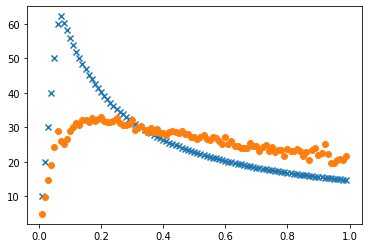

In [19]:
## Replicating Experiment 6.1 in the text

n = 1000
points = 100

xs = []
us = []
ys = []

for ix in tqdm(range(1, points)):
    gap = ix / points
    
    m = two_arm_m(n, gap)
    bandit = Bandit(build_two_gaussian(delta=gap))
    etc = ETCAlgorithm(bandit, m, n=n, repetitions=10**4)
    
    upper = two_arm_bound(n, gap)
    empir = etc.empirical_regret()
    
    # tracking for graphing
    xs.append(gap)
    us.append(upper)
    ys.append(empir)

plt.scatter(xs, us, marker='x')
plt.scatter(xs, ys)
plt.show()